In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import torch
import torch.nn as nn
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import math

In [2]:
import gdown

gdown.download_folder('https://drive.google.com/drive/folders/1UKUZZ6uTdEVdGWEKNh0ZRp08pK_AVnrm', output='Download')

pd.set_option('display.max_columns', None)
df = pd.read_csv('Download/subject_data.csv')

Retrieving folder contents


Processing file 1wHcBG5ScNKOxQixT6XZElaYYnLe5YtTh images.hdf5
Processing file 19NhzTlMREy2ct5kaXJyuZjSrgrSq2zIOMSiiTuGCPbI metadata
Processing file 1RZTnXKRaoVzszG8zQgBgmdnGyGXL_CO3rmbf3QpDNbU Problem Statement
Processing file 1N9oQCi5zklHrv-AXRF6RBiiAzmxc4i2y subject_data.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1wHcBG5ScNKOxQixT6XZElaYYnLe5YtTh
From (redirected): https://drive.google.com/uc?id=1wHcBG5ScNKOxQixT6XZElaYYnLe5YtTh&confirm=t&uuid=19b92663-4a1e-4d39-a296-66ff9fb8fe28
To: /kaggle/working/Download/images.hdf5
100%|██████████| 1.30G/1.30G [00:06<00:00, 213MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=19NhzTlMREy2ct5kaXJyuZjSrgrSq2zIOMSiiTuGCPbI
From (redirected): https://docs.google.com/spreadsheets/d/19NhzTlMREy2ct5kaXJyuZjSrgrSq2zIOMSiiTuGCPbI/export?format=xlsx
To: /kaggle/working/Download/metadata
52.7kB [00:00, 7.81MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1RZTnXKRaoVzszG8zQgBgmdnGyGXL_CO3rmbf3QpDNbU
From (redirected): https://docs.google.com/document/d/1RZTnXKRaoVzszG8zQgBgmdnGyGXL_CO3rmbf3QpDNbU/export?format=docx
To: /kaggle/working/Download/Problem Statement
78.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [4]:
# !pip install h5py
import h5py
images_file = 'Download/images.hdf5'


images_hdf5 = h5py.File(images_file, 'r')
img_keys = list(images_hdf5.keys())


def get_img(key):
  if key not in img_keys: return None
  img = Image.open(io.BytesIO(images_hdf5[key][()]))
  return np.array(img)

def get_img_pil(key):
  if key not in img_keys: return None
  return Image.open(io.BytesIO(images_hdf5[key][()]))


In [5]:
import os
from PIL import Image
import io
import h5py
from tqdm.auto import tqdm



output_dir = 'Images'
os.makedirs(output_dir, exist_ok=True)

print(f"Extracting images from {images_file} to {output_dir}...")

for img_id in tqdm(img_keys, desc="Extracting Images"):
    try:
        img_data = images_hdf5[img_id][()]
        img = Image.open(io.BytesIO(img_data))
        img_path = os.path.join(output_dir, f"{img_id}.jpg") # Save as JPEG
        img.save(img_path)
    except Exception as e:
        print(f"Error extracting image {img_id}: {e}")

print("Image extraction complete.")

images_hdf5.close()

Extracting images from Download/images.hdf5 to Images...


Extracting Images:   0%|          | 0/401059 [00:00<?, ?it/s]

Image extraction complete.


In [6]:
# different types of malignancy
df_malignant = df[df.iloc[:, 1] == 1].iloc[:, 49]
df_malignant.value_counts().sort_index()

iddx_3
Basal cell carcinoma                 163
Melanoma Invasive                     63
Melanoma in situ                      80
Melanoma metastasis                    1
Melanoma, NOS                         13
Squamous cell carcinoma in situ       49
Squamous cell carcinoma, Invasive     22
Squamous cell carcinoma, NOS           2
Name: count, dtype: int64

Basal cell carcinoma (163 images)


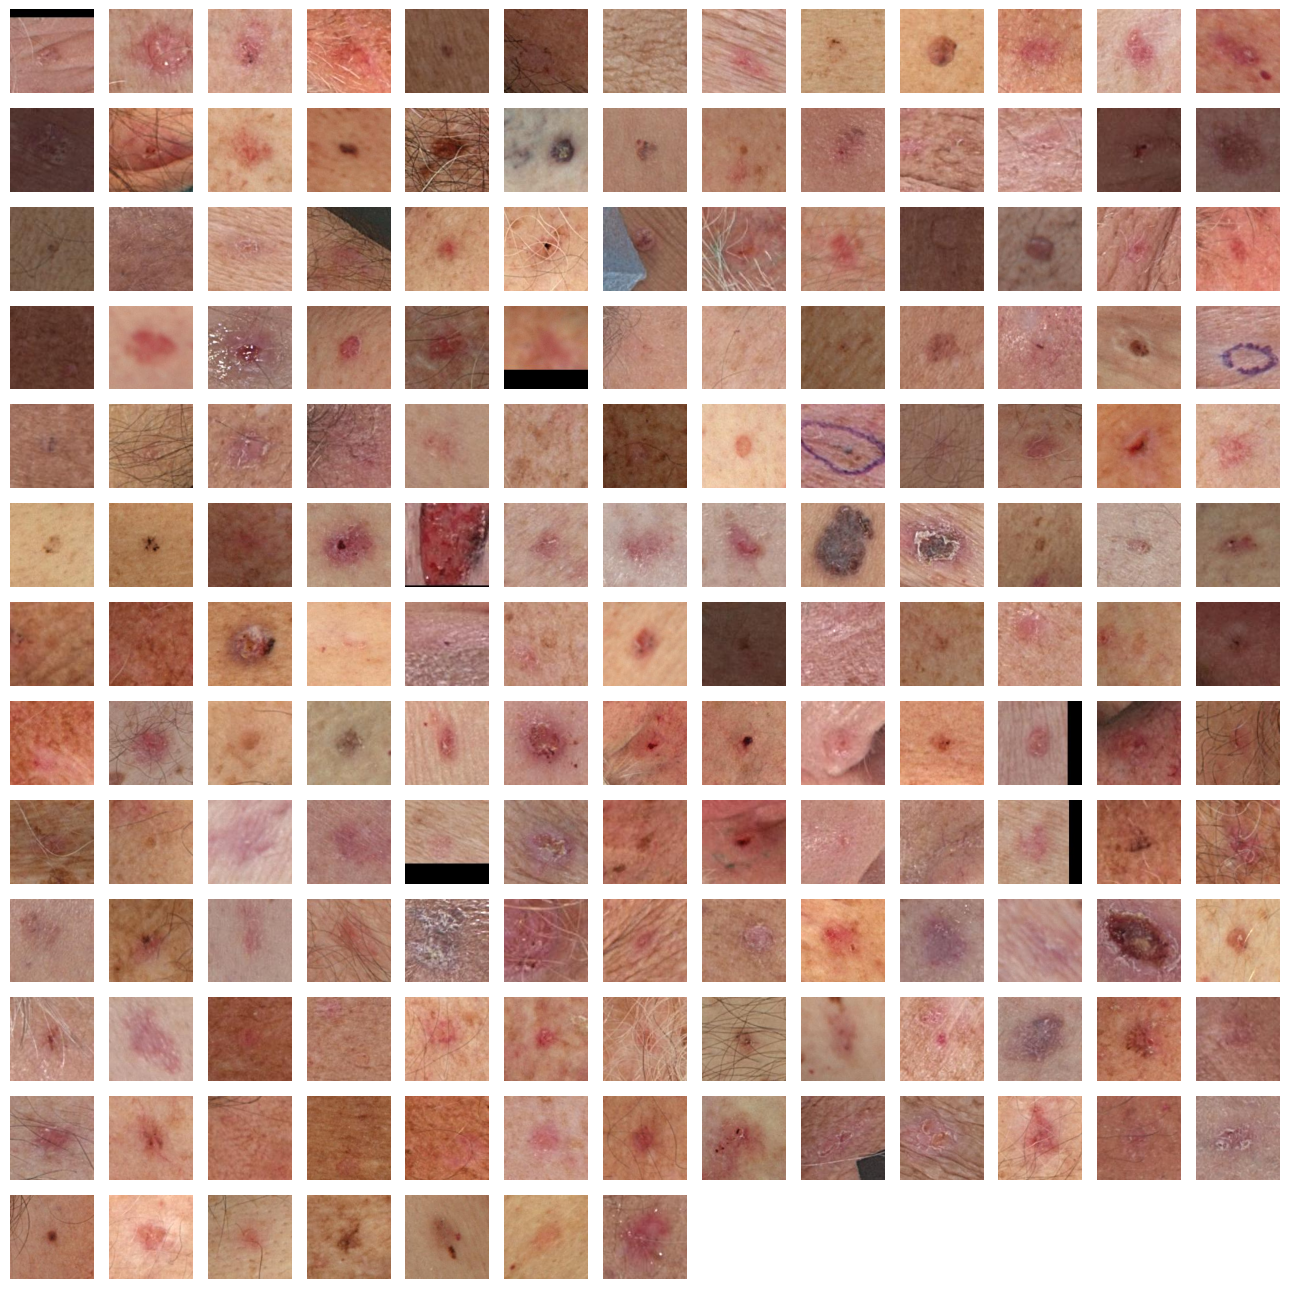

Melanoma Invasive (63 images)


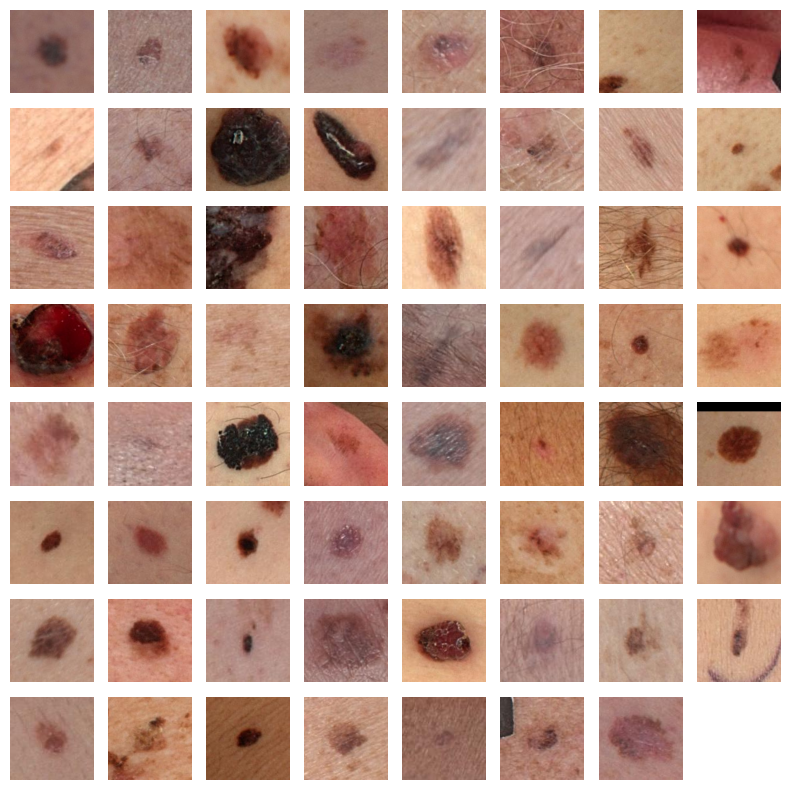

Melanoma in situ (80 images)


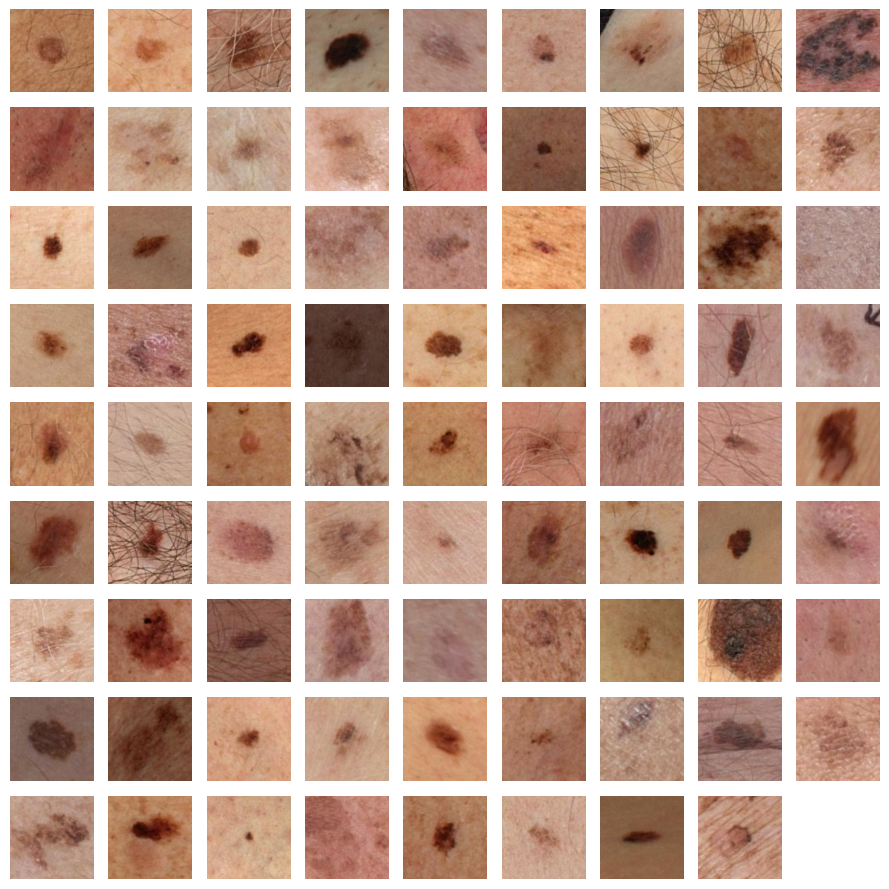

Melanoma metastasis (1 images)


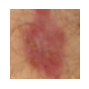

Melanoma, NOS (13 images)


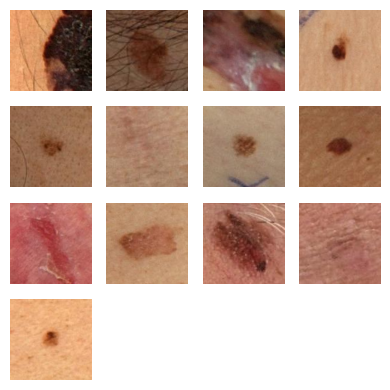

Squamous cell carcinoma in situ (49 images)


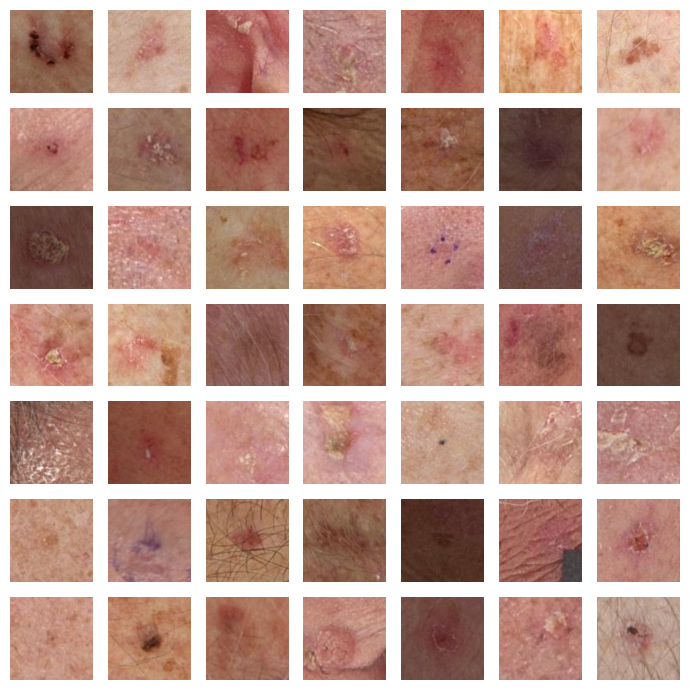

Squamous cell carcinoma, Invasive (22 images)


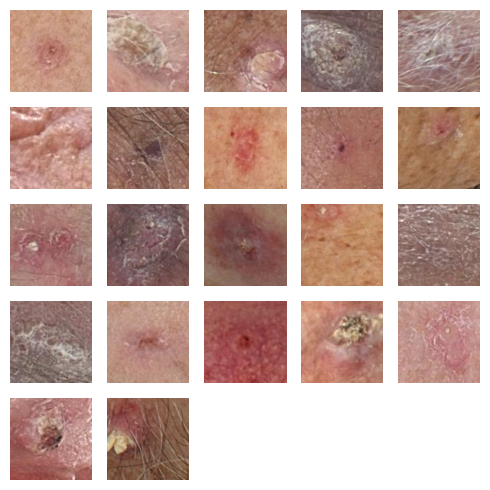

Squamous cell carcinoma, NOS (2 images)


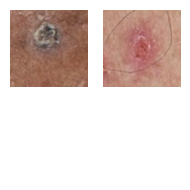

In [7]:
# !pip install h5py
import h5py
images_file = 'Download/images.hdf5'


images = h5py.File(images_file, 'r')
img_keys = list(images.keys())



def get_img_cell(key):
  if key not in img_keys: return None
  return Image.open(io.BytesIO(images[key][()]))

for t in np.sort(df_malignant.unique()):
    df_temp = df[df['iddx_3'] == t]
    imgs = df_temp.iloc[:, 0].to_numpy()

    n_imgs = len(imgs)
    print(f"{t} ({n_imgs} images)")  # print instead of suptitle

    grid_size = math.ceil(math.sqrt(n_imgs))  # square grid

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size, grid_size))
    axes = np.atleast_1d(axes).flatten()  # always make 1D

    for ax, img_path in zip(axes, imgs):
        ax.imshow(get_img_cell(img_path))
        ax.axis('off')

    # Hide extra axes
    for ax in axes[n_imgs:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## The archetecture im planning
```
Images ── EfficientNet     ─┐
                            ├─ [Fusion] ── Head 1: Benign / Malignant
Tabular Data ── MLP ────────┘              Head 2: Malignant Subtype
```

In [11]:
!pip install geffnet git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-2o8rhqv7
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-2o8rhqv7
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 7021d63a49106e22c79b40564a7d39930e7b0f53
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import torch
import torch.nn as nn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import cv2
import albumentations
from tqdm import tqdm

In [2]:
class CancerDataset(Dataset):
    def __init__(self, csv, mode, meta_features, transform=None, imgs_dir="Images"):

        self.csv = csv.reset_index(drop=True)
        self.mode = mode
        self.meta_features = meta_features

        self.meta_df = self.csv[self.meta_features]
        self.transform = transform
        self.imgs_dir = imgs_dir


    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):

        row = self.csv.iloc[index]
        img_id = row.isic_id
        image_path = os.path.join(self.imgs_dir, f"{img_id}.jpg")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)

        meta_data = self.meta_df.iloc[index].values.astype(np.float32)
        data = (torch.tensor(image).float(), torch.tensor(meta_data).float())

        if self.mode == 'test':
            return data
        else:
            return data, torch.tensor(self.csv.iloc[index].target).long(), torch.tensor(self.csv.iloc[index].subtype).long()

In [3]:
def get_transforms(image_size):

    transforms_train = albumentations.Compose([
        albumentations.Transpose(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
        albumentations.OneOf([
            albumentations.MotionBlur(blur_limit=5),
            albumentations.MedianBlur(blur_limit=5),
            albumentations.GaussianBlur(blur_limit=5),
            albumentations.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        albumentations.OneOf([
            albumentations.OpticalDistortion(distort_limit=1.0),
            albumentations.GridDistortion(num_steps=5, distort_limit=1.),
            albumentations.ElasticTransform(alpha=3),
        ], p=0.7),

        albumentations.CLAHE(clip_limit=4.0, p=0.7),
        albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        albumentations.Resize(image_size, image_size),
        albumentations.Normalize()
    ])

    transforms_val = albumentations.Compose([
        albumentations.Resize(image_size, image_size),
        albumentations.Normalize()
    ])

    return transforms_train, transforms_val

In [4]:
import torch
import torch.nn as nn
import geffnet


sigmoid = nn.Sigmoid()


class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)


class Effnet(nn.Module):
    def __init__(self, enet_type, out_dim, n_meta_features=0, n_meta_dim=[512, 128], pretrained=False):
        nn.Module.__init__(self)
        self.n_meta_features = n_meta_features
        self.enet = geffnet.create_model(enet_type, pretrained=pretrained)
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        in_ch = self.enet.classifier.in_features
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                Swish_Module(),
                nn.Dropout(p=0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                Swish_Module(),
            )
            in_ch += n_meta_dim[1]
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x).squeeze(-1).squeeze(-1)
        if self.n_meta_features > 0:
            x_meta = self.meta(x_meta)
            x = torch.cat((x, x_meta), dim=1)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out = self.myfc(dropout(x))
            else:
                out += self.myfc(dropout(x))
        out /= len(self.dropouts)
        return out

In [5]:
import torch
import torch.nn as nn
import geffnet

sigmoid = nn.Sigmoid()


class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)


class MultiEffnetShared(nn.Module):
    def __init__(self, enet_type, out_dim, n_meta_features=0, n_meta_dim=[512, 128], pretrained=False):
        super().__init__()
        self.n_meta_features = n_meta_features

        # Shared Image Backbone
        self.enet = geffnet.create_model(enet_type, pretrained=pretrained)
        in_ch_backbone = self.enet.classifier.in_features
        self.enet.classifier = nn.Identity()

        # Malignant Subtype Head
        self.subtype_hidden_dim = 256
        self.subtype_proj = nn.Sequential(
            nn.Linear(in_ch_backbone, self.subtype_hidden_dim),
            nn.BatchNorm1d(self.subtype_hidden_dim),
            Swish_Module(),
        )
        self.subtype_head = nn.Linear(self.subtype_hidden_dim, 4)  # 3 malignant classes

        # Meta Features Branch
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                Swish_Module(),
                nn.Dropout(p=0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                Swish_Module(),
            )
            in_ch_backbone += n_meta_dim[1]

        # Add subtype-projected features to final fusion
        in_ch_fusion = in_ch_backbone + self.subtype_hidden_dim

        # Final classification head
        self.dropouts = nn.ModuleList([nn.Dropout(0.5) for _ in range(5)])
        self.myfc = nn.Linear(in_ch_fusion, out_dim)

    def forward(self, x, x_meta=None):
        # Shared backbone features
        x_backbone = self.enet(x).squeeze(-1).squeeze(-1)

        # Subtype branch (hidden + logits)
        x_sub = self.subtype_proj(x_backbone)
        subtype_logits = self.subtype_head(x_sub)

        # Meta features
        feats = [x_backbone]
        if self.n_meta_features > 0 and x_meta is not None:
            feats.append(self.meta(x_meta))

        # Concatenate subtype hidden features (not raw backbone again)
        feats.append(x_sub)
        x_fused = torch.cat(feats, dim=1)

        # Dropout averaging trick
        out = None
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out = self.myfc(dropout(x_fused))
            else:
                out += self.myfc(dropout(x_fused))
        out /= len(self.dropouts)

        return out, subtype_logits

In [6]:
from warmup_scheduler import GradualWarmupScheduler

class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [52]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR


def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target, subtype_target) in bar:

        optimizer.zero_grad()

        if args.use_meta:
            data, meta = data
            data, meta, target, subtype_target = data.to(device), meta.to(device), target.to(device), subtype_target.to(device)
            out, subtype_logits = model(data, meta)
        else:
            data, target, subtype_target = data.to(device), target.to(device), subtype_target.to(device)
            out, subtype_logits = model(data)

        # main + auxiliary losses
        loss_main = criterion_main(out, target)
        loss_sub  = criterion_sub(subtype_logits, subtype_target)
        
        # weighted sum
        loss = loss_main + args.alpha * loss_sub

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))

    train_loss = np.mean(train_loss)
    return train_loss


def get_trans(img, I):

    if I >= 4:
        img = img.transpose(2, 3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)


def val_epoch(model, loader, mel_idx, is_ext=None, n_test=1, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PROBS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target, subtype_target) in tqdm(loader):

            if args.use_meta:
                data, meta = data
                data, meta, target, subtype_target = data.to(device), meta.to(device), target.to(device), subtype_target.to(device)
                logits = torch.zeros((data.shape[0], args.out_dim)).to(device)
                probs = torch.zeros((data.shape[0], args.out_dim)).to(device)
                for I in range(n_test):
                    out, subtype_logits = model(get_trans(data, I), meta)
                    logits += out
                    probs += out.softmax(1)
            else:
                data, target = data.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], args.out_dim)).to(device)
                probs = torch.zeros((data.shape[0], args.out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I))
                    logits += l
                    probs += l.softmax(1)
            logits /= n_test
            probs /= n_test

            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())
            TARGETS.append(target.detach().cpu())

            loss_main = criterion_main(logits, target)
            val_loss.append(loss_main.detach().cpu().numpy())

    val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS).numpy()
    PROBS = torch.cat(PROBS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()

    if get_output:
        return LOGITS, PROBS, TARGETS
    else:
      acc = (probs.argmax(1) == TARGETS).mean() * 100.
      auc = roc_auc_score((TARGETS == mel_idx).astype(float), probs[:, mel_idx])

      return val_loss, acc, auc



def run(fold, df, meta_features, n_meta_features, transforms_train, transforms_val, mel_idx, model=None, optim=None, scheduler=None):
    df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)

    dataset_train = CancerDataset(df_train, 'train', meta_features, transform=transforms_train)
    dataset_valid = CancerDataset(df_valid, 'valid', meta_features, transform=transforms_val)

    class_counts = df_train['target'].value_counts().sort_index()
    class_weights_dict = (1. / class_counts).to_dict()
    samples_weight = df_train['target'].map(class_weights_dict)
    sampler = WeightedRandomSampler(list(samples_weight.values), num_samples=len(samples_weight), replacement=True)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, sampler=sampler, num_workers=args.num_workers)
    print("Has Imbalance!")


    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=args.batch_size, num_workers=args.num_workers)

    if isinstance(args.n_meta_dim, str):
        n_meta_dim_list = [int(nd) for nd in args.n_meta_dim.split(',')]
    else:
        n_meta_dim_list = args.n_meta_dim

    if model is None:
        model = MultiEffnetShared(
            args.enet_type,
            n_meta_features=n_meta_features,
            n_meta_dim=n_meta_dim_list,
            out_dim=args.out_dim,
            pretrained=True
        )
    else:
      print("Model found, using pretrained one")
    model = model.to(device)

    auc_max = 0.
    model_file  = os.path.join(args.model_dir, f'{args.kernel_type}_best_fold{fold}.pth')
    model_file3 = os.path.join(args.model_dir, f'{args.kernel_type}_final_fold{fold}.pth')
    scheduler_file = os.path.join(args.model_dir, f'{args.kernel_type}_scheduler_final_fold{fold}.pth')
    optim_file = os.path.join(args.model_dir, f'{args.kernel_type}_optim_final_fold{fold}.pth')

    optimizer = optim
    if optimizer is None: optimizer = optim.Adam(model.parameters(), lr=args.init_lr)
    if DP:
        model = nn.DataParallel(model)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, args.n_epochs - 1)
    scheduler_warmup = scheduler
    if scheduler_warmup is not None: scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, args.n_epochs):
        print(time.ctime(), f'Fold {fold}, Epoch {epoch}')

        train_loss = train_epoch(model, train_loader, optimizer)
        # val_loss, acc, auc = val_epoch(model, valid_loader, mel_idx, is_ext=df_valid['is_ext'].values if 'is_ext' in df_valid.columns else None)


        # content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}.'
        # print(content)

        # scheduler_warmup.step()
        # if epoch==2: scheduler_warmup.step()

        # if auc > auc_max:
        #     print('Saving model ...'.format(auc_max, auc))
        #     torch.save(model.state_dict(), model_file)
        #     auc_max = auc

        # torch.save(optimizer.state_dict(), optim_file)
        # torch.save(scheduler_warmup.state_dict(), scheduler_file)

    # torch.save(model.state_dict(), model_file3)

In [51]:
args = argparse.Namespace()
args.model_dir = "Models"
args.log_dir = "Logs"
args.CUDA_VISIBLE_DEVICES = "0"
args.enet_type = 'efficientnet_b3'
args.kernel_type = 'efficientnet'
args.n_meta_dim = [512, 128]
args.out_dim = 2
args.data_dir = '/content'
args.data_folder = 'Download'
args.use_meta = True
args.batch_size = 32
args.num_workers = 2
args.image_size = 128
args.fold = 0
args.n_epochs = 2
args.init_lr = 1e-4
args.DEBUG = False
args.alpha = 0.01

os.makedirs(args.model_dir, exist_ok=True)
os.makedirs(args.log_dir, exist_ok=True)
os.environ['CUDA_VISIBLE_DEVICES'] = args.CUDA_VISIBLE_DEVICES
DP = len(os.environ['CUDA_VISIBLE_DEVICES']) > 1

set_seed()

device = torch.device('cuda')
criterion_main = nn.CrossEntropyLoss()   # for overall target
criterion_sub  = nn.CrossEntropyLoss()   # for subtype target

In [10]:
from sklearn.model_selection import StratifiedKFold
def map_labels(label):
    if pd.isna(label):
        return 3
    label = label.lower()
    if "basal cell carcinoma" in label:
        return 0
    elif "melanoma" in label:
        return 1
    elif "squamous cell carcinoma" in label:
        return 2
    else:
        return 3
def get_df(kernel_type, out_dim, data_dir, data_folder, use_meta):
    df = pd.read_csv(os.path.join(data_dir, data_folder, 'subject_data.csv'), low_memory=False)
    df = df[df['image_type'] == 'TBP tile: close-up']

    if "iddx_3" in df.columns:   # assumes subtype info is in "diagnosis"
        df["subtype"] = df["iddx_3"].apply(map_labels)
    else:
        raise ValueError("Expected a 'iddx_3 column in subject_data.csv for subtype mapping")

    if use_meta:
        meta_features = ['age_approx', 'sex', 'clin_size_long_diam_mm',
       'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_minorAxisMM', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle']

        if 'age_approx' in meta_features:
            df['age_approx'] = df['age_approx'].fillna(df['age_approx'].mean())

        if 'sex' in meta_features:
            df['sex'] = df['sex'].fillna(df['sex'].mode()[0])

        if 'sex' in meta_features:
            df = pd.get_dummies(df, columns=['sex'], dummy_na=False)
            meta_features.remove('sex')
            meta_features.extend([col for col in df.columns if 'sex_' in col])

        if 'tbp_lv_location' in meta_features:
             df = pd.get_dummies(df, columns=['tbp_lv_location'], dummy_na=False)
             meta_features.remove('tbp_lv_location')
             meta_features.extend([col for col in df.columns if 'tbp_lv_location_' in col and col != 'tbp_lv_location_simple'])

        for col in meta_features:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if df[col].isnull().any():
                    if df[col].dtype == 'float64':
                         df[col] = df[col].fillna(df[col].mean())
                    else:
                         df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 0)


        n_meta_features = len([col for col in df.columns if col in meta_features])

    else:
        meta_features = None
        n_meta_features = 0

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(df, df['target'])):
        df.loc[val_index, 'fold'] = fold

    mel_idx = sorted(df['target'].unique()).index(1)


    return df, meta_features, n_meta_features, mel_idx

In [11]:
from sklearn.utils.class_weight import compute_class_weight

args.kernel_type = 'efficientnet'
args.out_dim = 2
args.data_dir = '/kaggle/working'
args.data_folder = 'Download'
args.use_meta = True
args.batch_size = 1024
args.num_workers = 2
args.image_size = 64

df, meta_features, n_meta_features, mel_idx = get_df(
    args.kernel_type,
    args.out_dim,
    args.data_dir,
    args.data_folder,
    args.use_meta
)

fold = 0

transforms_train, transforms_val = get_transforms(args.image_size)

df_train = df[df['fold'] != fold]
df_valid = df[df['fold'] == fold]

dataset_train = CancerDataset(df_train, 'train', meta_features, transform=transforms_train)
dataset_valid = CancerDataset(df_valid, 'valid', meta_features, transform=transforms_val)

class_weights = compute_class_weight('balanced',
                                   classes=np.unique(df['target']),
                                   y=df['target'])
class_weight_dict = dict(zip(np.unique(df['target']), class_weights))
sample_weights = df_valid['target'].map(class_weight_dict)
sampler = WeightedRandomSampler(list(sample_weights), num_samples=len(df_valid), replacement=True)

# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, sampler=RandomSampler(dataset_train), num_workers=args.num_workers)
# valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=args.batch_size, num_workers=args.num_workers)

/tmp/ipykernel_151/1215327332.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  albumentations.GaussNoise(var_limit=(5.0, 30.0)),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [12]:
model = MultiEffnetShared(
    args.enet_type,
    n_meta_features=n_meta_features,
    n_meta_dim=[int(nd) for nd in args.n_meta_dim.split(',')] if isinstance(args.n_meta_dim, str) else args.n_meta_dim,
    out_dim=args.out_dim,
    pretrained=True
)
model = nn.DataParallel(model)
model = model.to(device)

# Define Optimizer and Criterion
optimizer = optim.Adam(model.parameters(), lr=args.init_lr)
criterion = nn.CrossEntropyLoss()

# Define Learning Rate Scheduler (already partially defined in run function)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, args.n_epochs - 1)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

print("Model initialized, optimizer and criterion defined.")

Model initialized, optimizer and criterion defined.


In [53]:
# Execute Training
fold = 0
run(fold, df, meta_features, n_meta_features, transforms_train, transforms_val, mel_idx, model, optimizer, scheduler_warmup)

print("Training complete.")

Has Imbalance!
Model found, using pretrained one
320847 80212
Sat Aug 16 14:03:44 2025 Fold 0, Epoch 1


loss: 0.03435, smth: 0.12178: 100%|██████████| 10027/10027 [21:22<00:00,  7.82it/s]


Training complete.


In [54]:
torch.save(model.state_dict(), 'multieffnet_fold0_epoch4.pth')

In [67]:
model.load_state_dict(torch.load('multieffnet_fold0_epoch3.pth', weights_only=False))

<All keys matched successfully>

In [68]:
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=args.batch_size, num_workers=args.num_workers)

val_out = val_epoch(model, valid_loader, mel_idx, get_output=True)

logits, probs, targets = val_out

preds = probs.argmax(1)

tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()

print(f"Confusion Matrix:\n[[{tn}, {fp}], [{fn}, {tp}]]")

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value (Precision): {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")
print(f"F1 Score: {f1_score:.4f}")

from sklearn.metrics import roc_auc_score
auc = roc_auc_score((targets == mel_idx).astype(float), probs[:, mel_idx])
print(f"AUC: {auc:.4f}")

100%|██████████| 2507/2507 [01:06<00:00, 37.82it/s]


Confusion Matrix:
[[79122, 1012], [5, 73]]

Accuracy: 0.9873
Sensitivity (Recall): 0.9359
Specificity: 0.9874
Positive Predictive Value (Precision): 0.0673
Negative Predictive Value: 0.9999
F1 Score: 0.1255
AUC: 0.9949


In [69]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

dataset_mal = CancerDataset(df[df['target'] == 1], 'valid', meta_features, transform=transforms_val)

mal_loader = torch.utils.data.DataLoader(dataset_mal, batch_size=args.batch_size, num_workers=args.num_workers)

mal_out = val_epoch(model, mal_loader, mel_idx, get_output=True)

logits, probs, targets = mal_out

preds = probs.argmax(1)

tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()

print(f"Confusion Matrix:\n[[{tn}, {fp}], [{fn}, {tp}]]")

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value (Precision): {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")
print(f"F1 Score: {f1_score:.4f}")

from sklearn.metrics import roc_auc_score
# auc = roc_auc_score((targets == mel_idx).astype(float), probs[:, mel_idx])
# print(f"AUC: {auc:.4f}")

100%|██████████| 13/13 [00:00<00:00, 22.85it/s]

Confusion Matrix:
[[0, 0], [32, 361]]

Accuracy: 0.9186
Sensitivity (Recall): 0.9186
Specificity: 0.0000
Positive Predictive Value (Precision): 1.0000
Negative Predictive Value: 0.0000
F1 Score: 0.9576


In [70]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.utils.data import WeightedRandomSampler

class_weights = compute_class_weight('balanced',
                                   classes=np.unique(df['target']),
                                   y=df['target'])
class_weight_dict = dict(zip(np.unique(df['target']), class_weights))
sample_weights = df_valid['target'].map(class_weight_dict)
sampler = WeightedRandomSampler(list(sample_weights), num_samples=len(df_valid), replacement=True)

valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=args.batch_size, num_workers=args.num_workers, sampler=sampler)

sampled_out = val_epoch(model, valid_loader, mel_idx, get_output=True)

logits, probs, targets = sampled_out

preds = probs.argmax(1)

tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()

print(f"Confusion Matrix:\n[[{tn}, {fp}], [{fn}, {tp}]]")

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value (Precision): {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")
print(f"F1 Score: {f1_score:.4f}")

from sklearn.metrics import roc_auc_score
auc = roc_auc_score((targets == mel_idx).astype(float), probs[:, mel_idx])
print(f"AUC: {auc:.4f}")

100%|██████████| 2507/2507 [01:06<00:00, 37.44it/s]

Confusion Matrix:
[[39740, 491], [2597, 37384]]

Accuracy: 0.9615
Sensitivity (Recall): 0.9350
Specificity: 0.9878
Positive Predictive Value (Precision): 0.9870
Negative Predictive Value: 0.9387
F1 Score: 0.9603
AUC: 0.9950
